In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import pickle

from scipy.stats.mstats import gmean

from cnp.cnp import StandardPredPreyConvGNP, FullConvGNP
from cnp.cov import (
    MeanFieldGaussianLayer,
    InnerprodGaussianLayer,
    KvvGaussianLayer,
    ExponentialCopulaLayer
)
from cnp.lnp import StandardPredPreyConvNP

import stheno
from shutil import copyfile

from collections import OrderedDict

from itertools import product

import matplotlib

from cnp.experiment import WorkingDirectory
# matplotlib.rcParams['text.usetex'] = True

# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

In [2]:
args_num_basis_dim = 32
args_jitter = 1e-4

In [3]:
def load_model(model_name, device, working_directory):
    
    if 'convgnp' in model_name and not('fullconvgnp' in model_name):
        
        output_layer = None

        if 'meanfield' in model_name:
            output_layer = MeanFieldGaussianLayer()

        elif 'innerprod' in model_name:
            output_layer = InnerprodGaussianLayer(num_embedding=args_num_basis_dim,
                                                  noise_type='hetero',
                                                  jitter=args_jitter)

        elif 'kvv' in model_name:
            output_layer = KvvGaussianLayer(num_embedding=args_num_basis_dim,
                                            noise_type='hetero',
                                            jitter=args_jitter)

        if 'exponential' in model_name:
            output_layer = ExponentialCopulaLayer(gaussian_layer=output_layer,
                                                  device=device)

        model = StandardPredPreyConvGNP(input_dim=1,
                                        output_layer=output_layer)
        
    elif 'convnp' in model_name:
        model = StandardPredPreyConvNP(input_dim=1, num_samples=16)

    elif 'fullconvgnp' in model_name:
        model = FullConvGNP(points_per_unit_mean=16,
                            points_per_unit_kernel=8)

    # Load model to appropriate device
    model = model.to(device)

    # Load model from saved state
    load_dict = torch.load(working_directory.file(f'{model_name}', exists=True), map_location=torch.device('cpu'))
    model.load_state_dict(load_dict['state_dict'])
    
    return model

In [4]:
# root = '../../experiments/predator-prey/results'
# data = 'sim-pred-prey-100-16-50-100-100-0'

# copyfile(f'{root}/{data}/models/convGNP/meanfield/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-meanfield-identity')
# copyfile(f'{root}/{data}/models/convGNP/innerprod/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-innerprod-identity')
# copyfile(f'{root}/{data}/models/convGNP/kvv/hetero/identity/seed-0/model_best.pth.tar', 'models/convgnp-kvv-identity')

# copyfile(f'{root}/{data}/models/convGNP/meanfield/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-meanfield-exponential')
# copyfile(f'{root}/{data}/models/convGNP/innerprod/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-innerprod-exponential')
# copyfile(f'{root}/{data}/models/convGNP/kvv/hetero/exponential/seed-0/model_best.pth.tar', 'models/convgnp-kvv-exponential')

# copyfile(f'{root}/{data}/models/convNP/meanfield/homo/identity/seed-0/model_best.pth.tar', 'models/convnp-identity')
# copyfile(f'{root}/{data}/models/FullConvGNP/meanfield/homo/identity/seed-0/model_best.pth.tar', 'models/fullconvgnp-identity')

# copyfile(f'../../experiments/predator-prey/simulated-data/sim-pred-prey-100-16-50-100-100-0/valid-data.pkl', 'data.pkl')

model_directory = WorkingDirectory('/scratches/cblgpu07/em626/kernelcnp/kernelcnp/notebooks/pred-prey-results/models')
# model_directory = WorkingDirectory('/Users/stratis/repos/kernelcnp/kernelcnp/notebooks/pred-prey-results/models')
device = torch.device('cpu')

Root: /scratches/cblgpu07/em626/kernelcnp/kernelcnp/notebooks/pred-prey-results/models


# Load data

In [5]:
file = open('data.pkl', 'rb')
batch = pickle.load(file)[0][1]
file.close()

device = torch.device('cpu')

x_context = batch['x_context'][:1, :, None].to(device)
y_context = batch['y_context'][:1, 0, :, None].to(device) / 100 + 1e-2
x_target = batch['x_target'][:1, :, None].to(device)
y_target = batch['y_target'][:1, 0, :, None].to(device) / 100 + 1e-2


x_context = x_context[:, ::5, :][:, :x_context.shape[1]//2, :]
y_context = y_context[:, ::5, :][:, :y_context.shape[1]//2, :]
x_target = x_target[:, :, :]
y_target = y_target[:, :, :]


x_context = torch.cat([x_context[:, :4, :], x_context[:, 5:, :]], axis=1)
y_context = torch.cat([y_context[:, :4, :], y_context[:, 5:, :]], axis=1)

# Posterior plots

In [6]:
models = [
    ('ConvGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-identity'),
    ('ConvGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-identity'),
    ('ConvGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-identity'),
    ('ConvNP', StandardPredPreyConvNP, 'convnp-identity'),
    ('ConvCGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-exponential'),
    ('ConvCGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-exponential'),
    ('ConvCGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-exponential'),
    ('FullConvGNP', FullConvGNP, 'fullconvgnp-identity'),
]

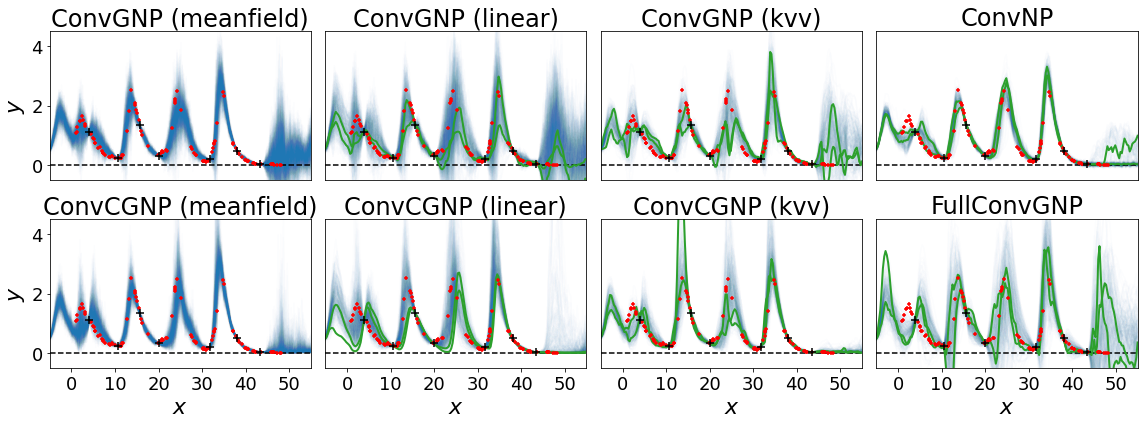

In [7]:
num_noisy_samples = 256
num_noiseless_samples = 2

x_plot = torch.linspace(-5., 55., 200)[None, :, None].to(device)

fig = plt.figure(figsize=(16, 6))

for i, (model_title, model_class, model_name) in enumerate(models):
    
    plt.subplot(2, 4, i+1)
    
    # Load model
    model = load_model(model_name, device=device, working_directory=model_directory)
    
    # Draw samples (noisy and noiseless)
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noisy_samples,
                           noiseless=False,
                           double=True)
    
    # Plot data and samples
    plt.plot(to_numpy(x_plot[0, :, 0]),
             to_numpy(samples[:, 0, :]).T,
             color='tab:blue',
             alpha=0.01,
             zorder=1,
             label='Noisy samples')
    
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noiseless_samples,
                           noiseless=True,
                           double=True)
    
    # Plot data and samples
    
    if not (model_name == 'convgnp-meanfield-identity' or \
            model_name == 'convgnp-meanfield-exponential'):
        plt.plot(to_numpy(x_plot[0, :, 0]),
                 to_numpy(samples[:, 0, :]).T,
                 color='tab:green',
                 alpha=1.0,
                 zorder=2,
                 linewidth=2,
                 label='Noiseless samples')
    
    plt.scatter(to_numpy(x_context)[0, :, 0],
                to_numpy(y_context)[0, :, 0],
                color='black',
                marker='+',
                s=50,
                zorder=4,
                label='Context')
    
    plt.scatter(to_numpy(x_target)[0, :, 0],
                to_numpy(y_target)[0, :, 0],
                color='red',
                marker='+',
                s=20,
                zorder=3,
                label='Target')
    
    plt.xlim([-5, 55])
    plt.ylim([-0.5, 4.5])
    
    if i < 4:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 50, 6), fontsize=18)
        plt.xlabel('$x$', fontsize=22)
    
    if i % 4 != 0:
        plt.yticks([])
        
    else:
        plt.yticks(np.linspace(0, 4, 3), fontsize=18)
        plt.ylabel('$y$', fontsize=22)
        
    plt.plot([-5., 55.], [0., 0.], '--', color='black', zorder=1)
        
    plt.title(model_title, fontsize=24)
    
handles, labels = plt.gca().get_legend_handles_labels()

# fig.legend(handles[-4:], labels[-4:], loc='center', ncol=1, fontsize=15, bbox_to_anchor=(1.0, 0.0, 0.5, 1.1), handletextpad=0.01, columnspacing=2.0)
plt.tight_layout()
plt.savefig('pred-prey-plots.pdf')
plt.show()

In [8]:
models = [
    ('ConvGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-identity'),
    ('ConvCGNP (meanfield)', StandardPredPreyConvGNP, 'convgnp-meanfield-exponential'),
    ('ConvGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-identity'),
    ('ConvCGNP (linear)', StandardPredPreyConvGNP, 'convgnp-innerprod-exponential'),
    ('ConvGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-identity'),
    ('ConvCGNP (kvv)', StandardPredPreyConvGNP, 'convgnp-kvv-exponential'),
    ('ConvNP', StandardPredPreyConvNP, 'convnp-identity'),
    ('FullConvGNP', FullConvGNP, 'fullconvgnp-identity'),
]

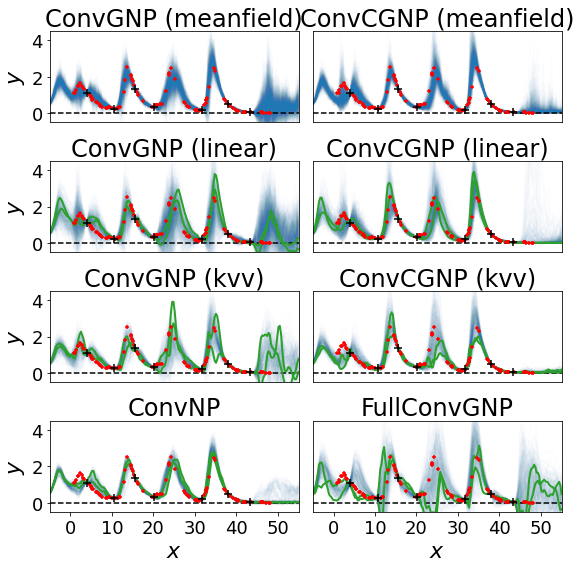

In [9]:
num_noisy_samples = 256
num_noiseless_samples = 2

x_plot = torch.linspace(-5., 55., 200)[None, :, None].to(device)

fig = plt.figure(figsize=(8, 8))

for i, (model_title, model_class, model_name) in enumerate(models):
    
    plt.subplot(4, 2, i+1)
    
    # Load model
    model = load_model(model_name, device=device, working_directory=model_directory)
    
    # Draw samples (noisy and noiseless)
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noisy_samples,
                           noiseless=False,
                           double=True)
    
    # Plot data and samples
    plt.plot(to_numpy(x_plot[0, :, 0]),
             to_numpy(samples[:, 0, :]).T,
             color='tab:blue',
             alpha=0.01,
             zorder=1,
             label='Noisy samples')
    
    samples = model.sample(x_context,
                           y_context,
                           x_plot,
                           num_samples=num_noiseless_samples,
                           noiseless=True,
                           double=True)
    
    # Plot data and samples
    
    if not (model_name == 'convgnp-meanfield-identity' or \
            model_name == 'convgnp-meanfield-exponential'):
        plt.plot(to_numpy(x_plot[0, :, 0]),
                 to_numpy(samples[:, 0, :]).T,
                 color='tab:green',
                 alpha=1.0,
                 zorder=2,
                 linewidth=2,
                 label='Noiseless samples')
    
    plt.scatter(to_numpy(x_context)[0, :, 0],
                to_numpy(y_context)[0, :, 0],
                color='black',
                marker='+',
                s=50,
                zorder=4,
                label='Context')
    
    plt.scatter(to_numpy(x_target)[0, :, 0],
                to_numpy(y_target)[0, :, 0],
                color='red',
                marker='+',
                s=20,
                zorder=3,
                label='Target')
    
    plt.xlim([-5, 55])
    plt.ylim([-0.5, 4.5])
    
    if i < 6:
        plt.xticks([])
    else:
        plt.xticks(np.linspace(0, 50, 6), fontsize=18)
        plt.xlabel('$x$', fontsize=22)
    
    if i % 2 != 0:
        plt.yticks([])
        
    else:
        plt.yticks(np.linspace(0, 4, 3), fontsize=18)
        plt.ylabel('$y$', fontsize=22)
        
    plt.plot([-5., 55.], [0., 0.], '--', color='black', zorder=1)
        
    plt.title(model_title, fontsize=24)
    
handles, labels = plt.gca().get_legend_handles_labels()

plt.tight_layout()
plt.savefig('pred-prey-plots-mod.pdf')
plt.show()

In [10]:
def argmax_prob(data, model, threshold, num_samples, max_num_context, max_num_target):

    probs = []
    prob_thresh = []
    min_abs_diffs = []
    max_abs_diffs = []
    
    with torch.no_grad():
        for epoch in data:

            for i, batch in enumerate(epoch):

                x_ctx = batch['x_context'][:, :, None].to(device)
                y_ctx = batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2
                x_trg = batch['x_target'][:, :, None].to(device)
                y_trg = batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2

                num_ctx = batch['x_context'].shape[1]
                _num_ctx = np.random.choice(np.arange(1, max_num_context+1)) if num_ctx > max_num_context else num_ctx
                ctx_idx = torch.randperm(num_ctx)[:_num_ctx]

                x_ctx = x_ctx[:, ctx_idx, :]
                y_ctx = y_ctx[:, ctx_idx, :]

                num_trg = batch['x_target'].shape[1]
                _num_trg = np.random.choice(np.arange(1, max_num_target+1)) if num_trg > max_num_target else num_trg
                trg_idx = torch.randperm(num_trg)[:_num_trg]

                x_trg = x_trg[:, trg_idx, :]
                y_trg = y_trg[:, trg_idx, :]

                samples = model.sample(x_ctx,
                                       y_ctx,
                                       x_trg,
                                       num_samples=num_samples,
                                       noiseless=False, # noiseless,
                                       double=True)

                argmax_model = torch.argmax(samples, axis=-1)

                argmax_true = torch.argmax(y_trg[:, :, 0], axis=-1)
                argmax_true = argmax_true[None, :].repeat(argmax_model.shape[0], 1)

                prob = torch.mean((argmax_true == argmax_model).float())

                probs.append(prob)

                max_model = torch.max(samples, axis=-1)[0]
                max_true = torch.max(y_trg[:, :, 0], axis=-1)[0]

                abs_diff = torch.mean(torch.abs(max_model - max_true[None, :]))
                max_abs_diffs.append(to_numpy(abs_diff))

                min_model = torch.min(samples, axis=-1)[0]
                min_true = torch.min(y_trg[:, :, 0], axis=-1)[0]

                abs_diff = torch.mean(torch.abs(min_model - min_true[None, :]))
                min_abs_diffs.append(to_numpy(abs_diff))

                # Apply threshold
                thresholded = torch.any(samples <= threshold, dim=-1) # (S, B)
                threshold_probs = torch.mean(thresholded.float(), dim=0)
                thresholded_true = torch.any(y_trg[:, :, 0] <= threshold, dim=-1)
                threshold_probs = thresholded_true.float() * threshold_probs + (1. - thresholded_true.float()) * (1. - threshold_probs)

                prob_thresh.append(to_numpy(threshold_probs))
                

                if i % 100 == 0:
                    print(gmean(probs), np.mean(prob_thresh), np.mean(min_abs_diffs), np.mean(max_abs_diffs))

In [11]:
file = open('data.pkl', 'rb')
data = pickle.load(file)
file.close()

model = load_model('convgnp-meanfield-identity', device=device, working_directory=model_directory)

argmax_prob(data, model=model, threshold=0.1, num_samples=256, max_num_context=5, max_num_target=100)

0.10986329 0.7607422 0.44280208192499126 0.820330455701637
0.06849383 0.6587506 0.5701370560706828 0.7310903821049067


KeyboardInterrupt: 

In [408]:
file = open('data.pkl', 'rb')
data = pickle.load(file)
file.close()

model = load_model('convgnp-kvv-identity', device=device, working_directory=model_directory)

argmax_prob(data, model=model, threshold=0.1, num_samples=256, max_num_context=5, max_num_target=100)

0.053710938 0.6184082 0.38481644958030037 0.9653505100178577
0.06139027 0.6500873 0.43144710886235 0.8200158478954095
0.05768104 0.66121167 0.43530360792280065 0.7902530912652271
0.058435183 0.6678907 0.4297311009143649 0.7833637890563183
0.05728599 0.6695358 0.4363845730828512 0.7956524855702335
0.056448042 0.6680279 0.4397125279806831 0.7819242540674315
0.056851875 0.66940576 0.43904274430159596 0.7845637498920045
0.055517577 0.6665039 0.4440665237375336 0.7906588857097717
0.058267914 0.67126036 0.43802771921449146 0.7904456973673454
0.05931012 0.67352825 0.43306462850025 0.7869511882296826
0.058691103 0.67566717 0.43192707389476725 0.7826016461526513


In [90]:
from scipy.interpolate import interp1d

def threshold_estimator(data, model, threshold, num_samples, max_num_context, max_num_target, num_grid):

    true_event_probs = []
    log_probs = []
    
    probs_all = torch.zeros(size=(0,))
    true_events_all = torch.zeros(size=(0,)).long()
    
    with torch.no_grad():
        for epoch in data:

            for i, batch in enumerate(epoch):

                x_ctx = batch['x_context'][:, :, None].to(device)
                y_ctx = batch['y_context'][:, 0, :, None].to(device) / 100 + 1e-2
                x_trg = batch['x_target'][:, :, None].to(device)
                y_trg = batch['y_target'][:, 0, :, None].to(device) / 100 + 1e-2
                
                x = batch['x'][:, :]
                y = batch['y'][:, 0, :] / 100 + 1e-2
                interps = [interp1d(x=_x.cpu().detach().numpy(), y=_y.cpu().detach().numpy()) for _x, _y in zip(x, y)]
                
                x_min = torch.min(x, axis=1)[0]
                x_max = torch.max(x, axis=1)[0]
                
                x_grid = [torch.linspace(_x_min, _x_max, num_grid) for _x_min, _x_max in zip(x_min, x_max)]
                x_grid = torch.stack(x_grid, axis=0)[:, :, None]
                y_grid = [interp(_x_grid[:, 0].cpu().detach().numpy()) for interp, _x_grid in zip(interps, x_grid)]
                y_grid = torch.tensor(y_grid)[:, :, None]
                
                # Subsample the context set
                num_ctx = batch['x_context'].shape[1]
                _num_ctx = np.random.choice(np.arange(1, max_num_context+1)) if num_ctx > max_num_context else num_ctx
                ctx_idx = torch.randperm(num_ctx)[:_num_ctx]

                x_ctx = x_ctx[:, ctx_idx, :]
                y_ctx = y_ctx[:, ctx_idx, :]

                # Subsample the target set
                num_trg = batch['x_target'].shape[1]
                _num_trg = np.random.choice(np.arange(1, max_num_target+1)) if num_trg > max_num_target else num_trg
                trg_idx = torch.randperm(num_trg)[:_num_trg]

                x_trg = x_trg[:, trg_idx, :]
                y_trg = y_trg[:, trg_idx, :]

                # Draw posterior samples
                samples = model.sample(x_ctx,
                                       y_ctx,
                                       x_grid,
                                       num_samples=num_samples,
                                       noiseless=False,
                                       double=True)
                
                y_ctx = y_ctx[:, :, 0]
                y_grid = y_grid[:, :, 0]
                
                # Estimate
                max_ctx = torch.max(y_ctx, dim=1)[0]
                max_ctx = max_ctx[:, None].repeat(1, y_grid.shape[1]) # (B, G)
                
                ctx_threshold = max_ctx + threshold
                event_true = torch.any(ctx_threshold <= y_grid, dim=1)
                
                ctx_threshold = ctx_threshold[None, :, :].repeat(num_samples, 1, 1) # (S, B, G)
                event_pred = torch.any(ctx_threshold <= samples, dim=2)
                event_pred = torch.mean(event_pred.float(), dim=0)
                event_pred = (1 - 2e-6) * event_pred + 1e-6
                
                log_prob = event_true.float() * torch.log(event_pred) + \
                           (1. - event_true.float()) * torch.log(1. - event_pred)
                
                log_probs.append(log_prob.mean().item())
                true_event_probs.append(torch.mean(event_true.float()).item())
                
                probs_all = torch.cat([probs_all, event_pred], axis=0)
                true_events_all = torch.cat([true_events_all, event_true.long()])
                
    if i % 100 == 0:
        print(f'{np.mean(log_probs):.3f}, {np.mean(true_event_probs):.3f}')
                    
    return np.mean(log_probs), probs_all, true_events_all

In [81]:
file = open('data.pkl', 'rb')
data = pickle.load(file)
file.close()

model = load_model('convgnp-meanfield-identity', device=device, working_directory=model_directory)

mf_log_probs_all, mf_true_events_all = threshold_estimator(data,
                                                           model=model,
                                                           threshold=0.5,
                                                           num_samples=128,
                                                           max_num_context=20,
                                                           max_num_target=100,
                                                           num_grid=300)

-1.422, 0.562
-1.333, 0.528
-1.326, 0.568
-1.362, 0.562
-1.334, 0.548
-1.342, 0.538
-1.355, 0.542
-1.379, 0.543
-1.357, 0.545
-1.334, 0.545
-1.344, 0.546


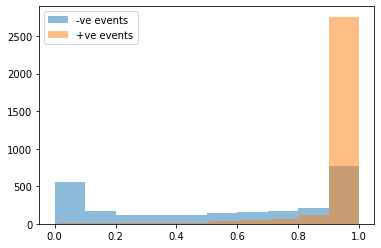

In [82]:
p = mf_log_probs_all.detach().cpu().numpy()
y = mf_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [83]:
file = open('data.pkl', 'rb')
data = pickle.load(file)
file.close()

model = load_model('convgnp-innerprod-identity', device=device, working_directory=model_directory)

ip_log_probs_all, ip_true_events_all = threshold_estimator(data,
                                                           model=model,
                                                           threshold=0.5,
                                                           num_samples=128,
                                                           max_num_context=20,
                                                           max_num_target=100,
                                                           num_grid=300)

-0.750, 0.375
-0.514, 0.502
-0.477, 0.539
-0.478, 0.541
-0.472, 0.542
-0.475, 0.536
-0.476, 0.541
-0.479, 0.542
-0.483, 0.542
-0.479, 0.543
-0.474, 0.547


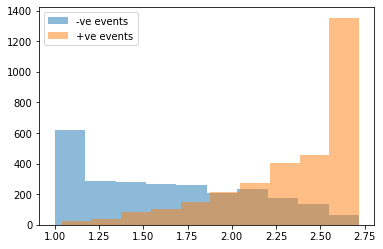

In [85]:
p = torch.exp(ip_log_probs_all).detach().cpu().numpy()
y = ip_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [86]:
file = open('data.pkl', 'rb')
data = pickle.load(file)
file.close()

model = load_model('convgnp-kvv-identity', device=device, working_directory=model_directory)

kvv_log_probs_all, kvv_true_events_all = threshold_estimator(data,
                                                             model=model,
                                                             threshold=0.5,
                                                             num_samples=128,
                                                             max_num_context=20,
                                                             max_num_target=100,
                                                             num_grid=300)

-0.355, 0.188
-0.414, 0.528
-0.405, 0.551
-0.423, 0.545
-0.421, 0.555
-0.433, 0.550
-0.431, 0.557
-0.439, 0.562
-0.442, 0.558
-0.440, 0.561
-0.438, 0.560


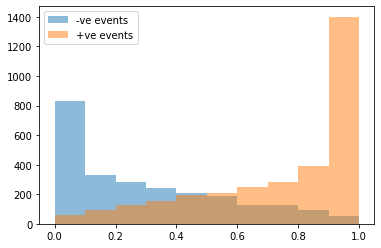

In [87]:
p = kvv_log_probs_all.detach().cpu().numpy()
y = kvv_true_events_all.detach().cpu().numpy()

plt.hist(p[np.where(y == 0)], alpha=0.5, label='-ve events')
plt.hist(p[np.where(y == 1)], alpha=0.5, label='+ve events')
plt.legend()
plt.show()

In [ ]:
thresholds = [0.1, 0.2, 0.5, 1.0, 1.5, 2.0]

results_mf = []
results_ip = []
results_kvv = []

for threshold in thresholds:
    
    print(f'Threshold {threshold:.3f}')

    model = load_model('convgnp-meanfield-identity', device=device, working_directory=model_directory)
    log_prob, mf_log_probs_all, mf_true_events_all = threshold_estimator(data,
                                                                         model=model,
                                                                         threshold=threshold,
                                                                         num_samples=256,
                                                                         max_num_context=20,
                                                                         max_num_target=100,
                                                                         num_grid=300)
    results_mf.append((log_prob, mf_log_probs_all, mf_true_events_all))

    model = load_model('convgnp-innerprod-identity', device=device, working_directory=model_directory)
    log_prob, ip_log_probs_all, ip_true_events_all = threshold_estimator(data,
                                                                         model=model,
                                                                         threshold=threshold,
                                                                         num_samples=256,
                                                                         max_num_context=20,
                                                                         max_num_target=100,
                                                                         num_grid=300)
    results_ip.append((log_prob, ip_log_probs_all, ip_true_events_all))

    model = load_model('convgnp-kvv-identity', device=device, working_directory=model_directory)
    log_prob, kvv_log_probs_all, kvv_true_events_all = threshold_estimator(data,
                                                                           model=model,
                                                                           threshold=threshold,
                                                                           num_samples=256,
                                                                           max_num_context=20,
                                                                           max_num_target=100,
                                                                           num_grid=300)
    results_kvv.append((log_prob, kvv_log_probs_all, kvv_true_events_all))

Threshold 0.100
Threshold 0.200
Threshold 0.500


In [ ]:
for results in [results_mf, results_ip, results_kvv]:
    
    log_probs = [tup[0] for tup in results]
    
    plt.plot(thresholds, log_probs)
plt.show()